# Classical ACGAN for MNIST Digit Generation

**Author:** David Strnadel  
**Date:** December 2025         
**Affiliation:** Faculty of Applied Informatics, Tomas Bata University in Zlin

## Abstract

This notebook documents the implementation of a baseline **Auxiliary Classifier GAN (ACGAN)** for the MNIST dataset, serving as a classical reference for comparison with the hybrid quantum variant **QACGAN** presented in the accompanying paper.

**Key Results:**
- Best **Fréchet Inception Distance (FID)**: **24.02** at epoch 20
- Best **Inception Score (IS)**: **2.23** at epoch 25
- Maximum external CNN classifier accuracy: **100%** at epoch 35
- Total training time: **≈27 minutes** on GPU (50 epochs)

**Training Configuration:**
- Latent dimension: 100
- Effective batch size: 64 (micro-batch 32 with 2 accumulation steps)
- Optimizer: Adam (lr = 2×10⁻⁴, β₁ = 0.5, β₂ = 0.999)
- Real-label smoothing: 0.9

This notebook covers the complete workflow: environment setup, data preparation, model architecture definition, training loop with gradient accumulation, metric evaluation (FID, IS, classification accuracy), and result visualization.

## 1. Reproducible Environment

This notebook is designed to run on **Google Colab** with GPU acceleration. Execute the cell below to install the required dependencies:

- **torch-fidelity**: Library for computing FID and Inception Score metrics
- **PyTorch** and **torchvision**: Deep learning framework (pre-installed on Colab)

> **Note:** The notebook supports CPU execution but training will be significantly slower. For optimal performance, ensure a GPU runtime is selected (Runtime → Change runtime type → GPU).

In [ ]:
!pip install torch-fidelity

In [ ]:
#@title 1. Install required libraries and imports
# Import PyTorch core, data handling tools, visualization, and metrics
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time
import shutil
import tempfile
from torch_fidelity import calculate_metrics
from torch.cuda.amp import autocast, GradScaler

# Set multiprocessing start method to 'spawn' for CUDA compatibility
try:
    torch.multiprocessing.set_start_method('spawn', force=True)
    print("Multiprocessing start method set to 'spawn'.")
except RuntimeError:
    print("Multiprocessing start method already set.")

# Confirm successful import of all libraries
print("Libraries successfully imported.")

Multiprocessing start method set to 'spawn'.
Libraries successfully imported.


## 2. Theoretical Background

### Generative Adversarial Networks (GANs)
GANs consist of two neural networks—a **Generator** $G$ and a **Discriminator** $D$—trained in an adversarial manner. The generator learns to produce synthetic samples from random noise, while the discriminator learns to distinguish real data from generated samples. This min-max game leads to the generator producing increasingly realistic outputs.

### Auxiliary Classifier GAN (ACGAN)
ACGAN extends the standard GAN framework by having the discriminator predict both:
1. **Source probability** (real vs. fake)
2. **Class label** of the input image

The generator $G(z, c)$ takes both a latent vector $z$ and a class label $c$ as input, enabling class-conditional image generation. This auxiliary classification task stabilizes training and improves the quality and class consistency of generated images.

### MNIST Dataset
The MNIST dataset consists of 60,000 training and 10,000 test grayscale images of handwritten digits (0–9), each 28×28 pixels. It serves as a standard benchmark for evaluating generative models.

> For detailed methodology and comparison with quantum-enhanced variants, see the accompanying paper.

In [ ]:
#@title 2. Device and path configuration
# Configure device (GPU/CPU) and directory structure for data and outputs

# Check GPU (CUDA) availability and enable TF32 for Ampere GPUs
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU available: {torch.cuda.get_device_name(0)}")

    # Enable TensorFloat-32 (TF32) on Ampere GPUs for better performance
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU (slower).")
    print("For TPU, uncomment and install torch_xla and modify the code.")

# Define paths to dataset, classifier weights, and output directories
BASE_DIR = "/content/"
DATA_DIR = os.path.join(BASE_DIR, "MNIST_data")
MNIST_DOWNLOAD_ROOT = DATA_DIR
MNIST_TRAIN_IMAGES_PATH = os.path.join(DATA_DIR, "MNIST_train_images_png")
CLASSIFIER_PATH = os.path.join(BASE_DIR, "mnist_classifier.pth")
OUTPUT_DIR_IMAGES = os.path.join(BASE_DIR, "acgan_images_output")
OUTPUT_DIR_MODELS = os.path.join(BASE_DIR, "acgan_models_output")
LOG_FILE = os.path.join(BASE_DIR, "acgan_training_logs.pkl")

# Create output directories if they don't exist
os.makedirs(OUTPUT_DIR_IMAGES, exist_ok=True)
os.makedirs(OUTPUT_DIR_MODELS, exist_ok=True)

print(f"Device: {device}")
print(f"MNIST root directory: {MNIST_DOWNLOAD_ROOT}")
print(f"Path for PNG MNIST images: {MNIST_TRAIN_IMAGES_PATH}")
print(f"Expected classifier path: {CLASSIFIER_PATH}")
print(f"Output directory for images: {OUTPUT_DIR_IMAGES}")
print(f"Output directory for models: {OUTPUT_DIR_MODELS}")

# Check if pretrained classifier exists; otherwise stop execution
if not os.path.exists(CLASSIFIER_PATH):
    print("\n" + "="*60)
    print(f"ERROR: Classifier file '{CLASSIFIER_PATH}' not found!")
    print("Please upload the file 'mnist_classifier.pth' to the Colab session root directory ('/content/').")
    print("Script execution stopped.")
    print("="*60)
    raise FileNotFoundError(f"Classifier file '{CLASSIFIER_PATH}' is missing. Please upload it.")
else:
    print(f"\nCheck OK: Classifier file '{CLASSIFIER_PATH}' found.")

GPU not available, using CPU (slower).
For TPU, uncomment and install torch_xla and modify the code.
Device: cpu
MNIST root directory: /content/MNIST_data
Path for PNG MNIST images: /content/MNIST_data/MNIST_train_images_png
Expected classifier path: /content/mnist_classifier.pth
Output directory for images: /content/acgan_images_output
Output directory for models: /content/acgan_models_output

Check OK: Classifier file '/content/mnist_classifier.pth' found.


## 3. Utility Functions

This section defines helper functions used throughout the training and evaluation pipeline:

- **`weights_init(m)`** — Initializes convolutional and batch normalization layers following DCGAN best practices: weights drawn from $\mathcal{N}(0, 0.02)$, biases set to zero.

- **`save_samples(epoch, ...)`** — Generates and saves sample images at each epoch to visually monitor training progress. Outputs both a grid image and individual class-labeled samples.

- **`save_mnist_as_images(...)`** — Converts the MNIST training set to individual PNG files, required by the `torch-fidelity` library for computing reference statistics in FID/IS evaluation.

In [ ]:
#@title 3. Utility functions
# Weight initialization according to DCGAN/ACGAN recommendations
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

# Generate and save sample images during training
def save_samples(epoch, generator, fixed_noise, fixed_labels, output_dir, device):
    generator.eval()
    with torch.no_grad():
        fixed_noise = fixed_noise.to(device)
        fixed_labels = fixed_labels.to(device)
        gen_imgs = generator(fixed_noise, fixed_labels)
        gen_imgs = gen_imgs * 0.5 + 0.5

    grid_path = os.path.join(output_dir, f"acgan_samples_epoch_{epoch:04d}_grid.png")
    save_image(gen_imgs.data, grid_path, nrow=5, normalize=False)

    fig, axs = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        row, col = i // 5, i % 5
        img_to_plot = gen_imgs[i].cpu().squeeze()
        axs[row, col].imshow(img_to_plot, cmap='gray')
        axs[row, col].set_title(f"Class: {fixed_labels[i].item()}")
        axs[row, col].axis('off')
    plt.tight_layout()
    plot_path = os.path.join(output_dir, f"acgan_mnist_epoch_{epoch:04d}_classes.png")
    plt.savefig(plot_path)
    plt.close(fig)

    print(f"Samples for epoch {epoch} saved: '{grid_path}' and '{plot_path}'")
    generator.train()

# Convert MNIST training set to separate PNG files for FID/IS evaluation
def save_mnist_as_images(dataset_path_root, output_dir):
    num_mnist_train = 60000
    if os.path.exists(output_dir):
        try:
            num_files = len([f for f in os.listdir(output_dir) if f.endswith('.png')])
            if num_files == num_mnist_train:
                print(f"Directory '{output_dir}' already exists and is complete ({num_files} PNG). Skipping generation.")
                return True
            else:
                print(f"Directory '{output_dir}' exists but is incomplete ({num_files}/{num_mnist_train} PNG). Deleting and regenerating.")
                shutil.rmtree(output_dir)
        except OSError as e:
            print(f"Error checking/deleting directory {output_dir}: {e}. Trying to continue...")

    os.makedirs(output_dir, exist_ok=True)
    print(f"Generating MNIST training images to directory '{output_dir}'...")

    transform_save = transforms.Compose([transforms.ToTensor()])
    try:
        mnist_dataset = datasets.MNIST(root=dataset_path_root, train=True, download=True, transform=transform_save)
        print(f"MNIST dataset found/downloaded in '{dataset_path_root}'")
    except Exception as download_e:
        print(f"FATAL: Failed to download or load MNIST dataset from '{dataset_path_root}'. Error: {download_e}")
        return False

    if len(mnist_dataset) != num_mnist_train:
        print(f"Warning: Expected number of images in MNIST training set is {num_mnist_train}, found {len(mnist_dataset)}.")

    count = 0
    try:
        for i in range(len(mnist_dataset)):
            image, label = mnist_dataset[i]
            save_image(image, os.path.join(output_dir, f"mnist_train_{i:05d}.png"), normalize=False)
            count += 1
            if (i + 1) % 10000 == 0:
                print(f"  Saved {i + 1}/{len(mnist_dataset)} images...")
        print(f"Successfully saved {count} MNIST training images to '{output_dir}'.")
        return True
    except Exception as save_e:
        print(f"ERROR saving image {count}: {save_e}")
        print("Saving interrupted. Directory may be incomplete.")
        return False

print("Utility functions defined.")

Utility functions defined.


## 4. Model Architecture

Both Generator and Discriminator follow DCGAN-style architectures adapted for ACGAN.

### Generator
| Layer | Description |
|-------|-------------|
| Input | Latent vector $z \in \mathbb{R}^{100}$ concatenated with class embedding $c \in \mathbb{R}^{10}$ |
| Linear | Projects to $256 \times 7 \times 7$ feature map |
| Block 1–3 | Upsample → Conv2d (3×3) → BatchNorm → LeakyReLU |
| Output | Conv2d (64 → 1, kernel 3×3) + Tanh → 28×28 grayscale image |

### Discriminator
| Layer | Description |
|-------|-------------|
| Input | 28×28 grayscale image |
| Block 1–4 | Conv2d (3×3, stride 2) → LeakyReLU → BatchNorm |
| Final Conv | Conv2d (128 → 256, 3×3, stride 2) → 4×4 feature map |
| Flatten | 256 × 4 × 4 = 4096 features |
| Adversarial head | Linear(4096 → 1) + Sigmoid → real/fake probability |
| Auxiliary head | Linear(4096 → 10) → class logits |

This architecture follows the design principles from the original DCGAN and ACGAN papers, using strided convolutions instead of pooling and batch normalization for training stability.

In [ ]:
#@title 5. Define function for generator quality evaluation
# Function computes FID, Inception Score, and classifier accuracy
def evaluate_model(epoch, generator, classifier, device, z_dim, num_classes,
                   eval_batch_size, num_samples_for_metrics, num_samples_for_accuracy,
                   mnist_png_path):
    # Basic setup and switch models to eval mode
    print(f"\n--- Starting evaluation for Epoch {epoch} ---")
    eval_start_time = time.time()
    generator.eval()
    classifier.eval()

    fid_score, is_score_mean, is_score_std, accuracy = float('nan'), float('nan'), float('nan'), float('nan')

    # Generate temporary images and compute FID/IS metrics
    temp_dir = None
    try:
        temp_dir = tempfile.mkdtemp()
        print(f"Generating {num_samples_for_metrics} samples for FID/IS to '{temp_dir}'...")
        img_counter = 0
        with torch.no_grad():
            num_batches = (num_samples_for_metrics + eval_batch_size - 1) // eval_batch_size
            for i in range(num_batches):
                current_batch_size = min(eval_batch_size, num_samples_for_metrics - img_counter)
                if current_batch_size <= 0:
                    break

                z = torch.randn(current_batch_size, z_dim, device=device)
                labels_gen = torch.randint(0, num_classes, (current_batch_size,), device=device)

                with autocast(enabled=torch.cuda.is_available()):
                    imgs = generator(z, labels_gen)

                for img_tensor in imgs.cpu():
                    if img_counter >= num_samples_for_metrics:
                        break
                    save_path = os.path.join(temp_dir, f"img_{img_counter:05d}.png")
                    save_image(img_tensor, save_path, normalize=True)
                    img_counter += 1
                if img_counter >= num_samples_for_metrics:
                    break

        if img_counter >= num_samples_for_metrics:
            print(f"Images saved ({img_counter}), computing FID/IS using torch-fidelity...")
            print(f"  Input 1 (generated): {temp_dir}")
            print(f"  Input 2 (reference): {mnist_png_path}")

            if not os.path.isdir(mnist_png_path) or not os.listdir(mnist_png_path):
                print(f"ERROR: Reference directory MNIST PNG '{mnist_png_path}' does not exist or is empty!")
                print("Skipping FID/IS computation.")
            else:
                try:
                    fidelity_num_workers = 2
                    metrics_dict = calculate_metrics(
                        input1=temp_dir,
                        input2=mnist_png_path,
                        cuda=torch.cuda.is_available(),
                        isc=True,
                        fid=True,
                        batch_size=eval_batch_size,
                        num_workers=fidelity_num_workers,
                        verbose=False
                    )

                    fid_score = metrics_dict.get('frechet_inception_distance', float('nan'))
                    is_score_mean = metrics_dict.get('inception_score_mean', float('nan'))
                    is_score_std = metrics_dict.get('inception_score_std', float('nan'))

                    print(f"FID: {fid_score:.4f}" if not np.isnan(fid_score) else "FID: Nebylo vypočítáno.")
                    print(f"Inception Score: {is_score_mean:.4f} ± {is_score_std:.4f}" if not np.isnan(is_score_mean) else "Inception Score: Not computed.")

                except Exception as e:
                    print(f"ERROR computing torch-fidelity metrics: {e}")
                    import traceback
                    traceback.print_exc()
                    fid_score, is_score_mean, is_score_std = float('nan'), float('nan'), float('nan')
        else:
            print(f"Insufficient generated samples ({img_counter}/{num_samples_for_metrics}) for metrics.")
            fid_score, is_score_mean, is_score_std = float('nan'), float('nan'), float('nan')

    except Exception as e:
        print(f"ERROR during image generation for metrics: {e}")
        fid_score, is_score_mean, is_score_std = float('nan'), float('nan'), float('nan')
    finally:
        if temp_dir and os.path.exists(temp_dir):
            try:
                shutil.rmtree(temp_dir)
            except Exception as e:
                print(f"Error deleting temporary directory {temp_dir}: {e}")

    # Test classifier accuracy on newly generated samples
    print(f"Generating {num_samples_for_accuracy} samples for classification test...")
    all_preds, all_targets = [], []
    num_samples_per_class = num_samples_for_accuracy // num_classes
    if num_samples_per_class == 0:
        print("Warning: num_samples_for_accuracy is too small to test all classes, accuracy will not be computed.")
    else:
        with torch.no_grad():
            for digit in range(num_classes):
                z = torch.randn(num_samples_per_class, z_dim, device=device)
                target_labels = torch.full((num_samples_per_class,), digit, dtype=torch.long, device=device)

                with autocast(enabled=torch.cuda.is_available()):
                    gen_imgs = generator(z, target_labels)
                    outputs = classifier(gen_imgs)

                _, predicted = torch.max(outputs.data, 1)
                all_preds.append(predicted.cpu())
                all_targets.append(target_labels.cpu())

        if all_preds:
            all_preds = torch.cat(all_preds)
            all_targets = torch.cat(all_targets)
            total_samples = len(all_targets)
            correct = (all_preds == all_targets).sum().item()
            accuracy = (100. * correct / total_samples) if total_samples > 0 else 0.0
            print(f"Classification accuracy of generated images: {accuracy:.2f}% ({correct}/{total_samples})")
        else:
            accuracy = float('nan')
            print("Classification accuracy not computed.")

    generator.train()
    eval_duration = time.time() - eval_start_time
    print(f"--- End Evaluation Epoch {epoch} (Duration: {eval_duration:.2f}s) ---")
    return fid_score, is_score_mean, accuracy

print("Evaluation function 'evaluate_model' defined.")

Evaluation function 'evaluate_model' defined.


## 6. Data Preparation

This section handles MNIST dataset loading and preprocessing:

1. **Download MNIST** — The dataset is automatically downloaded via torchvision if not already present
2. **Normalization** — Images are normalized to range $[-1, 1]$ to match the Tanh activation of the generator output
3. **DataLoader** — Batches of 32 images (micro-batch) are prepared with shuffling enabled
4. **PNG Export** — Training images are saved as individual PNG files for `torch-fidelity` to compute reference FID/IS statistics

> **Note:** The PNG conversion is performed once and cached. Subsequent runs will skip this step if the directory already contains the expected 60,000 images.

In [ ]:
#@title 8. Model Initialization, Loss Functions, Optimizers and Logging (BCELoss, AMP Disabled)
# Initialize models, losses, optimizers, classifier, logging structure, and disable AMP

import torch.optim as optim
import torch.nn as nn

generator = Generator(z_dim=Z_DIM, num_classes=NUM_CLASSES, img_channels=IMG_CHANNELS).to(device, memory_format=torch.channels_last)
discriminator = Discriminator(num_classes=NUM_CLASSES, img_channels=IMG_CHANNELS).to(device, memory_format=torch.channels_last)

generator.apply(weights_init)
discriminator.apply(weights_init)
print("Generator and Discriminator initialized, mved to device, and memory_format set to channels_last.")

adversarial_loss = nn.BCELoss().to(device)
auxiliary_loss = nn.CrossEntropyLoss().to(device)
print("Loss functions defined (BCE and CrossEntropy).")

optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
print("Adam optimizers for G and D created.")

classifier = MnistClassifier().to(device, memory_format=torch.channels_last)
try:
    classifier.load_state_dict(torch.load(CLASSIFIER_PATH, map_location=device, weights_only=True))
    classifier.eval()
    print(f"External classifier '{CLASSIFIER_PATH}' successfully loaded.")
except Exception as e:
    print(f"ERROR: Failed to load classifier state from '{CLASSIFIER_PATH}': {e}")
    print("NOTE: If error persists, try weights_only=False, but be aware of security risks.")
    raise e

fixed_noise = torch.randn(NUM_CLASSES, Z_DIM, device=device)
fixed_labels = torch.arange(0, NUM_CLASSES, dtype=torch.long, device=device)
print("Fixed noise and labels for sample images prepared.")

training_logs = {
    'params': {
        'z_dim': Z_DIM, 'num_classes': NUM_CLASSES, 'img_channels': IMG_CHANNELS,
        'effective_batch_size': EFFECTIVE_BATCH_SIZE,
        'micro_batch_size': MICRO_BATCH_SIZE,
        'accumulation_steps': ACCUMULATION_STEPS,
        'num_workers': NUM_WORKERS, 'num_epochs': NUM_EPOCHS,
        'lr': LEARNING_RATE, 'beta1': BETA1, 'beta2': BETA2, 'seed': SEED,
        'label_smoothing': LABEL_SMOOTHING, 'eval_interval': EVAL_INTERVAL,
        'num_samples_metrics': NUM_SAMPLES_FOR_METRICS, 'num_samples_accuracy': NUM_SAMPLES_FOR_ACCURACY
    },
    'epoch_times': [], 'total_training_time': None,
    'iterations': [], 'epochs': [],
    'g_loss': [], 'd_loss': [],
    'd_real_adv_loss': [], 'd_fake_adv_loss': [],
    'd_real_aux_loss': [], 'd_fake_aux_loss': [],
    'g_adv_loss': [], 'g_aux_loss': [],
    'eval_epochs': [], 'fid_scores': [], 'is_scores': [], 'classification_accuracy': []
}
best_fid = float('inf')
best_epoch = -1
print("Logging structure prepared.")

use_amp = False
print("AMP is explicitly disabled for this run.")

scaler_G = torch.amp.GradScaler(enabled=False)
scaler_D = torch.amp.GradScaler(enabled=False)
print(f"  GradScaler initialized with enabled=False.")

Generator and Discriminator initialized, moved to device, and memory_format set to channels_last.
Loss functions defined (BCE and CrossEntropy).
Adam optimizers for G and D created.
External classifier '/content/mnist_classifier.pth' successfully loaded.
Fixed noise and labels for sample images prepared.
Logging structure prepared.
AMP is explicitly disabled for this run.
  GradScaler initialized with enabled=False.


## 8. Training Loop

The training loop implements standard ACGAN training with gradient accumulation for effective larger batch sizes.

### Training Hyperparameters

| Parameter | Value | Description |
|-----------|-------|-------------|
| `NUM_EPOCHS` | 50 | Total training epochs |
| `MICRO_BATCH_SIZE` | 32 | Samples per forward pass |
| `ACCUMULATION_STEPS` | 2 | Gradient accumulation steps |
| `EFFECTIVE_BATCH_SIZE` | 64 | Effective batch size (32 × 2) |
| `LEARNING_RATE` | 2 × 10⁻⁴ | Adam learning rate |
| `BETA1`, `BETA2` | 0.5, 0.999 | Adam momentum parameters |
| `LABEL_SMOOTHING` | 0.9 | Smoothed real labels for discriminator |
| `EVAL_INTERVAL` | 5 epochs | Frequency of FID/IS evaluation |
| `SEED` | 42 | Random seed for reproducibility |

### Loss Functions
- **Adversarial loss**: Binary Cross-Entropy (BCE) for real/fake classification
- **Auxiliary loss**: Cross-Entropy for digit class prediction

### Training Dynamics
The discriminator and generator are trained alternately. Gradient accumulation allows for larger effective batch sizes while respecting GPU memory constraints. The best model (lowest FID) is automatically checkpointed during training.

**Best achieved FID: 24.02** at epoch 20.


Starting ACGAN training (BCELoss+Sigmoid, Smoothing, Without AMP)...
Number of epochs: 50
Device: cuda
Effective Batch size: 64 (Micro: 32, Steps: 2)
AMP: Vypnuto

[Epoch 1/50] [Effective Step 50] [Global Step 100] [D loss (micro): 1.0883] [G loss (micro): 0.5786] [D adv: 0.716] [D aux: 0.372] [G adv: 0.534] [G aux: 0.045]
[Epoch 1/50] [Effective Step 100] [Global Step 200] [D loss (micro): 1.0528] [G loss (micro): 0.3637] [D adv: 0.849] [D aux: 0.204] [G adv: 0.344] [G aux: 0.020]
[Epoch 1/50] [Effective Step 150] [Global Step 300] [D loss (micro): 0.8776] [G loss (micro): 0.3936] [D adv: 0.810] [D aux: 0.068] [G adv: 0.377] [G aux: 0.016]
[Epoch 1/50] [Effective Step 200] [Global Step 400] [D loss (micro): 0.9368] [G loss (micro): 0.5733] [D adv: 0.772] [D aux: 0.165] [G adv: 0.550] [G aux: 0.024]
[Epoch 1/50] [Effective Step 250] [Global Step 500] [D loss (micro): 0.8635] [G loss (micro): 0.4391] [D adv: 0.789] [D aux: 0.075] [G adv: 0.426] [G aux: 0.013]
[Epoch 1/50] [Effective St

<ipython-input-5-1da1e2560ffe>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Images saved (1000), calculating FID/IS using torch-fidelity...
  Input 1 (generated): /tmp/tmppctt93th
  Input 2 (reference): /content/MNIST_data/MNIST_train_images_png


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 43.5MB/s]
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)


FID: 32.7036
Inception Score: 2.1024 ± 0.0900
Generating 500 samples for classification test...
Classification accuracy of generated images: 87.80% (439/500)
--- End of Epoch 5 Evaluation (Duration: 61.29s) ---
*** New best FID: 32.7036 at epoch 5. Models saved as '_best.pth'. ***
----------------------------------------


<ipython-input-5-1da1e2560ffe>:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[Epoch 6/50] [Effective Step 4700] [Global Step 9405] [D loss (micro): 0.8642] [G loss (micro): 0.2861] [D adv: 0.858] [D aux: 0.006] [G adv: 0.285] [G aux: 0.001]
[Epoch 6/50] [Effective Step 4750] [Global Step 9505] [D loss (micro): 0.8381] [G loss (micro): 0.3293] [D adv: 0.836] [D aux: 0.002] [G adv: 0.329] [G aux: 0.000]
[Epoch 6/50] [Effective Step 4800] [Global Step 9605] [D loss (micro): 0.9508] [G loss (micro): 0.3511] [D adv: 0.851] [D aux: 0.100] [G adv: 0.351] [G aux: 0.000]
[Epoch 6/50] [Effective Step 4850] [Global Step 9705] [D loss (micro): 0.8356] [G loss (micro): 0.3060] [D adv: 0.835] [D aux: 0.001] [G adv: 0.306] [G aux: 0.000]
[Epoch 6/50] [Effective Step 4900] [Global Step 9805] [D loss (micro): 0.9075] [G loss (micro): 0.3149] [D adv: 0.853] [D aux: 0.055] [G adv: 0.314] [G aux: 0.001]
[Epoch 6/50] [Effective Step 4950] [Global Step 9905] [D loss (micro): 0.8862] [G loss (micro): 0.3205] [D adv: 0.885] [D aux: 0.001] [G adv: 0.320] [G aux: 0.000]
[Epoch 6/50] [Ef

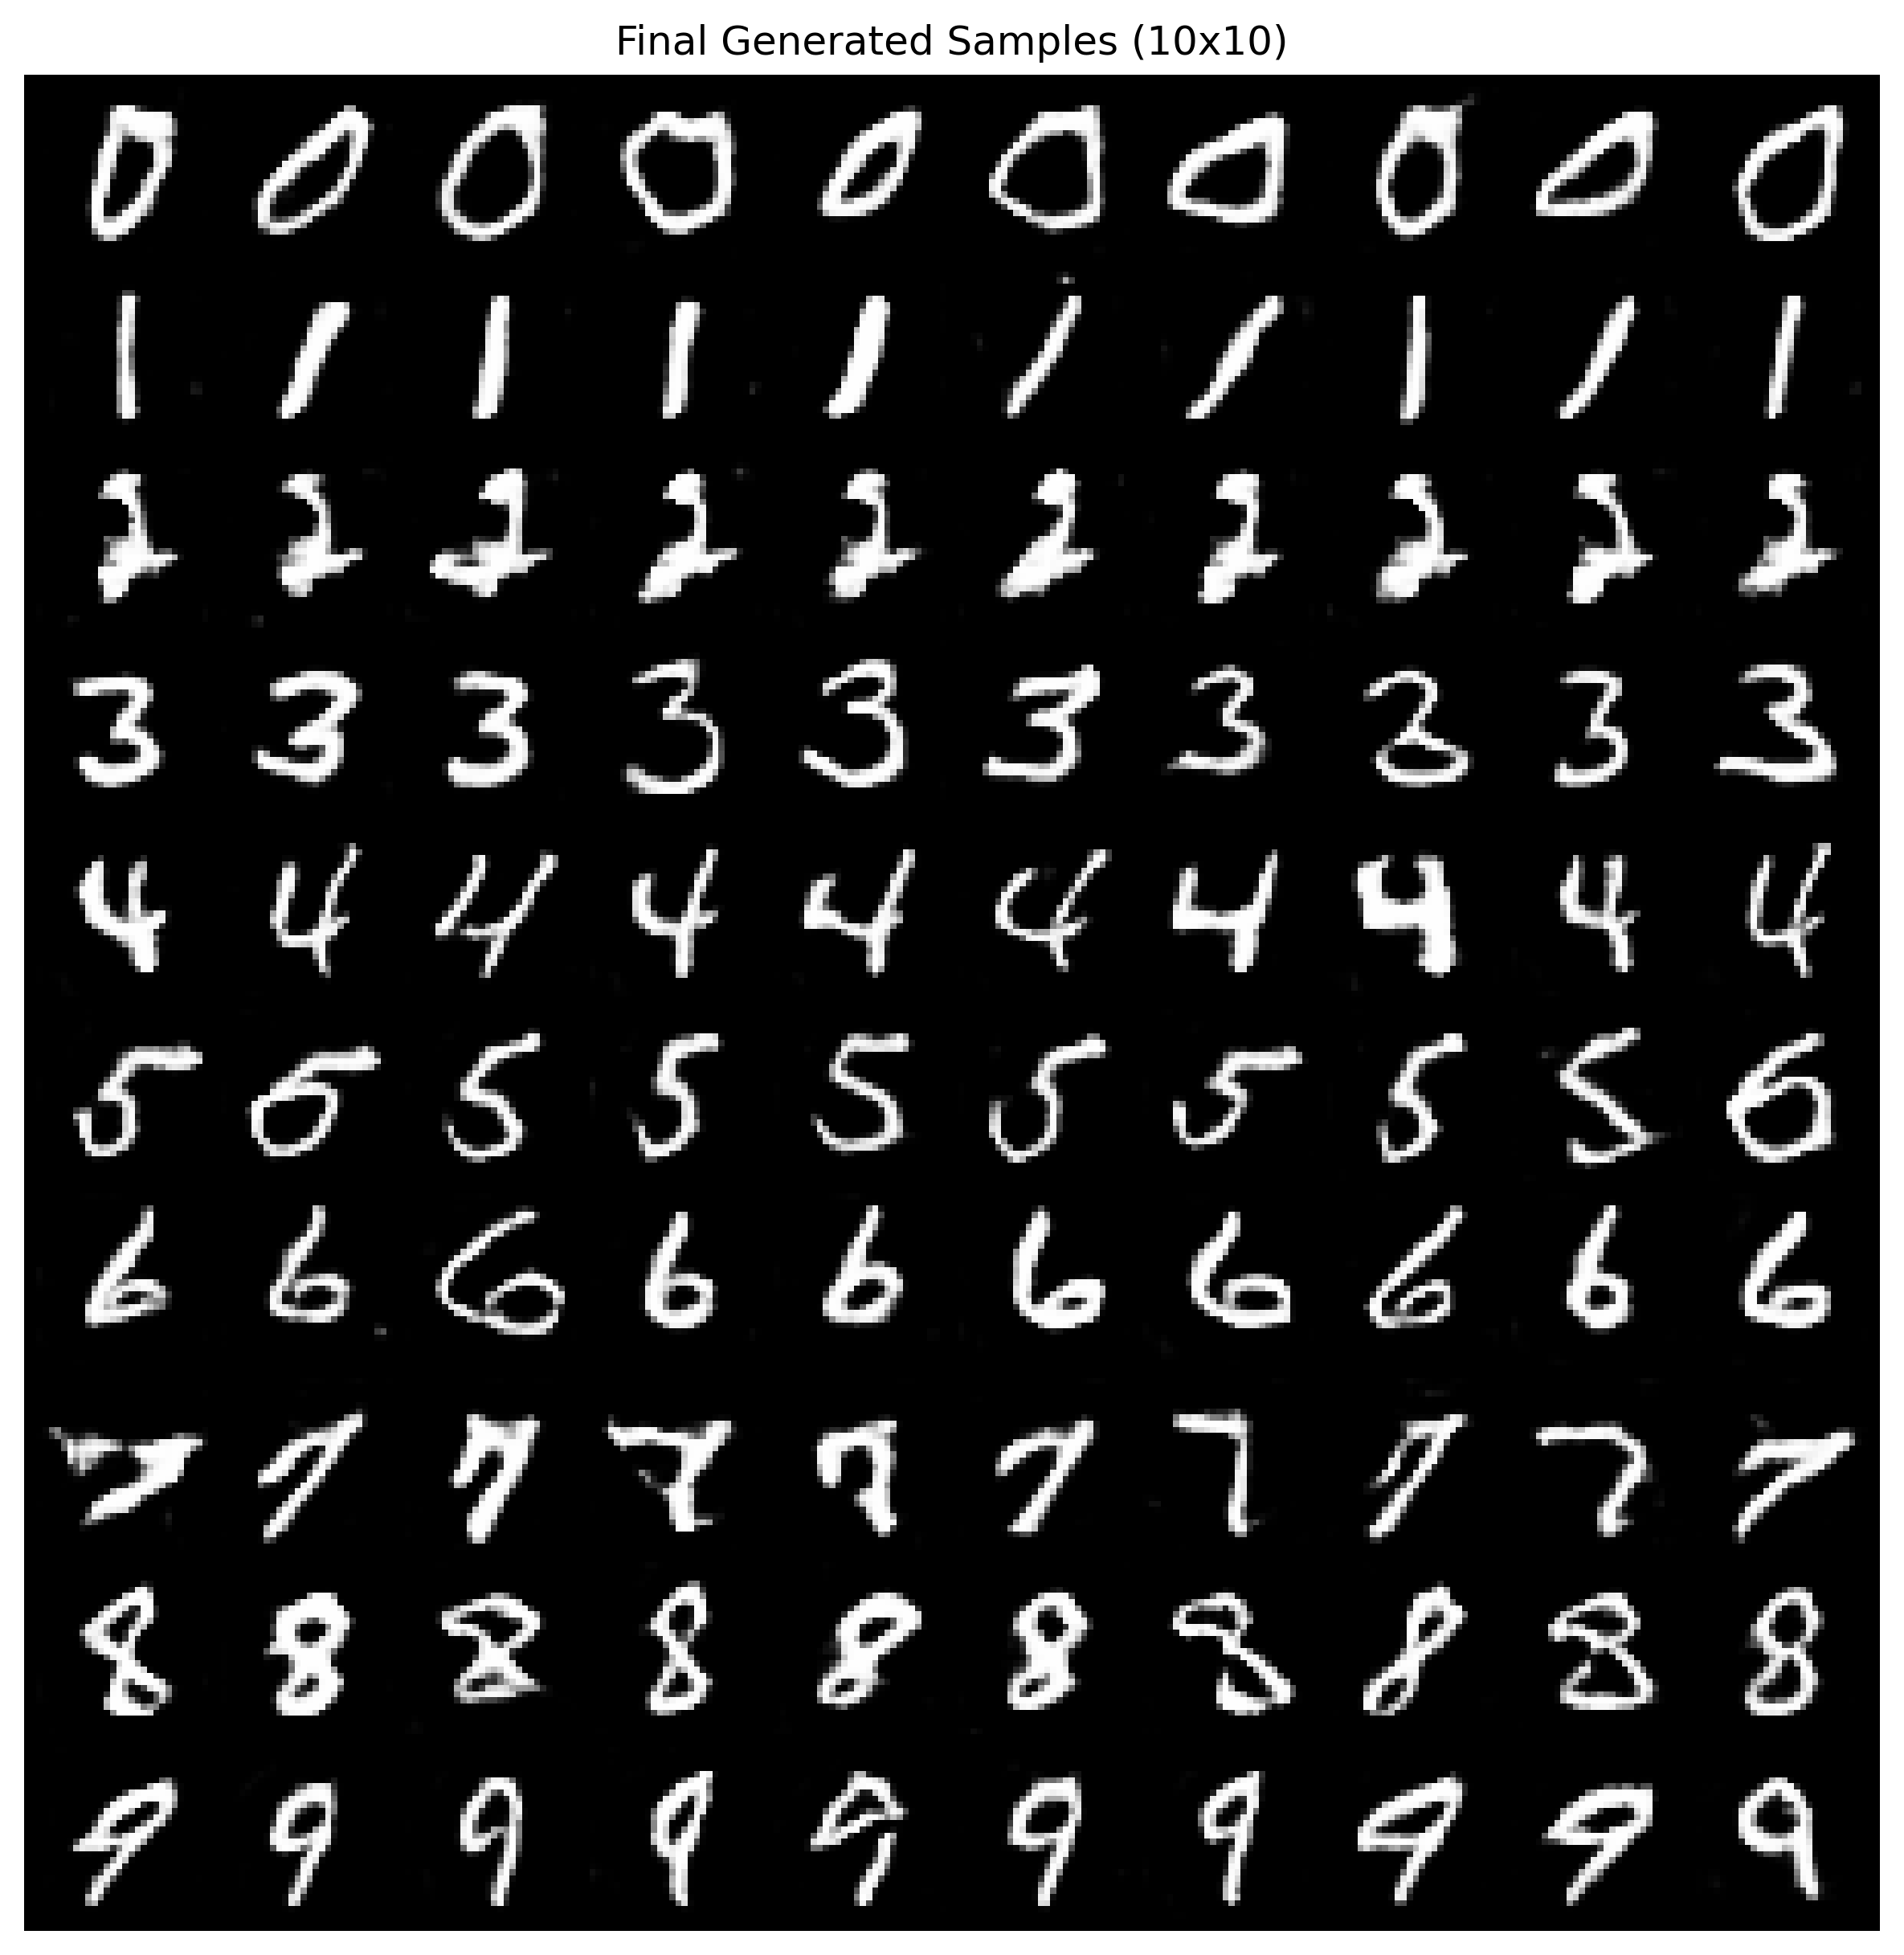

In [ ]:
#@title 9. ACGAN Training Loop (Final Version - BCELoss+Sigmoid, Smoothing, No AMP)
# <summary>Complete training loop with logging, evaluation, checkpointing and final visualization.</summary>

import torch
import time
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

print("\n" + "="*60)
print("Starting ACGAN training (BCELoss+Sigmoid, Smoothing, No AMP)...")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Device: {device}")
print(f"Effective Batch size: {EFFECTIVE_BATCH_SIZE} (Micro: {MICRO_BATCH_SIZE}, Steps: {ACCUMULATION_STEPS})")
print("AMP: Disabled")
print("="*60 + "\n")

total_start_time = time.time()
global_step = 0
effective_step = 0

optimizer_G.zero_grad(set_to_none=True)
optimizer_D.zero_grad(set_to_none=True)

if 'train_loader' in locals() and train_loader is not None:
    num_micro_batches_per_epoch = len(train_loader)
else:
    print("Warning: train_loader not defined! Number of steps per epoch will be unknown.")
    num_micro_batches_per_epoch = 1

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    epoch_g_loss_sum = 0.0
    epoch_d_loss_sum = 0.0
    generator.train()
    discriminator.train()

    if 'train_loader' not in locals() or train_loader is None:
        print("Error: train_loader not available for training loop.")
        break

    for i, (real_imgs, real_img_labels) in enumerate(train_loader):
        current_micro_batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device, memory_format=torch.channels_last)
        real_img_labels = real_img_labels.to(device)

        real_labels_tensor = torch.full((current_micro_batch_size, 1), LABEL_SMOOTHING, dtype=torch.float, device=device)
        fake_labels_tensor = torch.zeros((current_micro_batch_size, 1), dtype=torch.float, device=device)

        validity_real_prob, class_logits_real = discriminator(real_imgs)
        d_real_adv_loss = adversarial_loss(validity_real_prob, real_labels_tensor)
        d_real_aux_loss = auxiliary_loss(class_logits_real, real_img_labels)

        z_noise = torch.randn(current_micro_batch_size, Z_DIM, device=device)
        gen_labels = torch.randint(0, NUM_CLASSES, (current_micro_batch_size,), dtype=torch.long, device=device)
        with torch.no_grad():
            fake_imgs = generator(z_noise, gen_labels).detach()
        fake_imgs = fake_imgs.to(memory_format=torch.channels_last)

        validity_fake_prob, class_logits_fake = discriminator(fake_imgs)
        d_fake_adv_loss = adversarial_loss(validity_fake_prob, fake_labels_tensor)
        d_fake_aux_loss = auxiliary_loss(class_logits_fake, gen_labels)

        d_adv_loss_full = (d_real_adv_loss + d_fake_adv_loss) / 2
        d_aux_loss_full = (d_real_aux_loss + d_fake_aux_loss) / 2
        d_loss_full = d_adv_loss_full + d_aux_loss_full

        if not torch.isfinite(d_loss_full):
            raise ValueError(f'D loss is {d_loss_full} at step {global_step}, stopping training!')

        (d_loss_full / ACCUMULATION_STEPS).backward()

        z_noise_g = torch.randn(current_micro_batch_size, Z_DIM, device=device)
        gen_labels_g = torch.randint(0, NUM_CLASSES, (current_micro_batch_size,), dtype=torch.long, device=device)
        gen_imgs_g = generator(z_noise_g, gen_labels_g)
        gen_imgs_g = gen_imgs_g.to(memory_format=torch.channels_last)

        validity_g_prob, class_logits_g = discriminator(gen_imgs_g)

        real_labels_for_g = torch.ones((current_micro_batch_size, 1), dtype=torch.float, device=device)
        g_adv_loss_full = adversarial_loss(validity_g_prob, real_labels_for_g)
        g_aux_loss_full = auxiliary_loss(class_logits_g, gen_labels_g)
        g_loss_full = g_adv_loss_full + g_aux_loss_full

        if not torch.isfinite(g_loss_full):
            raise ValueError(f'G loss is {g_loss_full} at step {global_step}, stopping training!')

        (g_loss_full / ACCUMULATION_STEPS).backward()

        if (i + 1) % ACCUMULATION_STEPS == 0:
            effective_step += 1
            optimizer_D.step()
            optimizer_G.step()
            optimizer_D.zero_grad(set_to_none=True)
            optimizer_G.zero_grad(set_to_none=True)

            if effective_step % LOG_INTERVAL == 0:
                training_logs['iterations'].append(global_step + 1)
                training_logs['g_loss'].append(g_loss_full.item())
                training_logs['d_loss'].append(d_loss_full.item())
                training_logs['d_real_adv_loss'].append(d_real_adv_loss.item())
                training_logs['d_fake_adv_loss'].append(d_fake_adv_loss.item())
                training_logs['d_real_aux_loss'].append(d_real_aux_loss.item())
                training_logs['d_fake_aux_loss'].append(d_fake_aux_loss.item())
                training_logs['g_adv_loss'].append(g_adv_loss_full.item())
                training_logs['g_aux_loss'].append(g_aux_loss_full.item())

                print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] [Effective Step {effective_step}] [Global Step {global_step+1}] "
                      f"[D loss (micro): {d_loss_full.item():.4f}] [G loss (micro): {g_loss_full.item():.4f}] "
                      f"[D adv: {d_adv_loss_full.item():.3f}] [D aux: {d_aux_loss_full.item():.3f}] "
                      f"[G adv: {g_adv_loss_full.item():.3f}] [G aux: {g_aux_loss_full.item():.3f}]")

        epoch_g_loss_sum += g_loss_full.item()
        epoch_d_loss_sum += d_loss_full.item()
        global_step += 1

    epoch_duration = time.time() - epoch_start_time
    avg_g_loss = epoch_g_loss_sum / num_micro_batches_per_epoch if num_micro_batches_per_epoch > 0 else 0
    avg_d_loss = epoch_d_loss_sum / num_micro_batches_per_epoch if num_micro_batches_per_epoch > 0 else 0

    training_logs['epochs'].append(epoch + 1)
    training_logs['epoch_times'].append(epoch_duration)

    print("-" * 40)
    print(f"=== End of Epoch {epoch+1}/{NUM_EPOCHS} ===")
    print(f"Epoch time: {epoch_duration:.2f}s")
    print(f"Average G Loss (per micro-batch): {avg_g_loss:.4f}")
    print(f"Average D Loss (per micro-batch): {avg_d_loss:.4f}")
    print("-" * 40)

    if 'fixed_noise' in locals() and 'fixed_labels' in locals():
        save_samples(epoch + 1, generator, fixed_noise, fixed_labels, OUTPUT_DIR_IMAGES, device)
    else:
        print("Warning: fixed_noise or fixed_labels not defined, cannot save samples.")

    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
        required_eval_vars = ['classifier', 'Z_DIM', 'NUM_CLASSES', 'EVAL_BATCH_SIZE',
                              'NUM_SAMPLES_FOR_METRICS', 'NUM_SAMPLES_FOR_ACCURACY',
                              'MNIST_TRAIN_IMAGES_PATH']
        if all(var in locals() or var in globals() for var in required_eval_vars):
            fid, isc, acc = evaluate_model(
                epoch + 1, generator, classifier, device, Z_DIM, NUM_CLASSES,
                EVAL_BATCH_SIZE, NUM_SAMPLES_FOR_METRICS, NUM_SAMPLES_FOR_ACCURACY,
                MNIST_TRAIN_IMAGES_PATH
            )
            training_logs['eval_epochs'].append(epoch + 1)
            training_logs['fid_scores'].append(fid)
            training_logs['is_scores'].append(isc)
            training_logs['classification_accuracy'].append(acc)

            if not np.isnan(fid) and fid < best_fid:
                best_fid = fid
                best_epoch = epoch + 1
                best_generator_path = os.path.join(OUTPUT_DIR_MODELS, 'acgan_generator_best.pth')
                best_discriminator_path = os.path.join(OUTPUT_DIR_MODELS, 'acgan_discriminator_best.pth')
                try:
                    torch.save(generator.state_dict(), best_generator_path)
                    torch.save(discriminator.state_dict(), best_discriminator_path)
                    print(f"*** New best FID: {best_fid:.4f} at epoch {best_epoch}. Models saved as '_best.pth'. ***")
                except Exception as e:
                    print(f"ERROR saving best model: {e}")
            print("-" * 40)
        else:
            print("Warning: Missing variables needed for evaluation, evaluation skipped.")

total_training_time = time.time() - total_start_time
training_logs['total_training_time'] = total_training_time

print("\n" + "="*60)
print("Training completed!")
print(f"Total training time: {total_training_time:.2f}s ({total_training_time/3600:.2f} hours)")
print(f"Best FID: {best_fid:.4f} achieved at epoch {best_epoch}")
print("="*60 + "\n")

try:
    with open(LOG_FILE, 'wb') as f:
        pickle.dump(training_logs, f)
    print(f"Training logs successfully saved to: {LOG_FILE}")
except Exception as e:
    print(f"ERROR saving logs: {e}")

final_generator_path = os.path.join(OUTPUT_DIR_MODELS, 'acgan_generator_final.pth')
final_discriminator_path = os.path.join(OUTPUT_DIR_MODELS, 'acgan_discriminator_final.pth')
try:
    torch.save(generator.state_dict(), final_generator_path)
    torch.save(discriminator.state_dict(), final_discriminator_path)
    print(f"Final models saved to directory: '{OUTPUT_DIR_MODELS}'")
except Exception as e:
    print(f"ERROR saving final models: {e}")

print("\nGenerating final samples (10x10 grid)...")
generator.eval()
final_samples = []
samples_per_class_final = 10
with torch.no_grad():
    for digit in range(NUM_CLASSES):
        z_final = torch.randn(samples_per_class_final, Z_DIM, device=device)
        labels_final = torch.full((samples_per_class_final,), digit, dtype=torch.long, device=device)
        gen_imgs_final = generator(z_final, labels_final).detach().cpu()
        final_samples.append(gen_imgs_final)

if final_samples:
    all_final_samples_tensor = torch.cat(final_samples)
    grid_final = make_grid(all_final_samples_tensor, nrow=samples_per_class_final, normalize=True)
    final_grid_path = os.path.join(OUTPUT_DIR_IMAGES, "acgan_final_all_digits_grid.png")
    save_image(grid_final, final_grid_path)
    print(f"Final sample grid saved to: {final_grid_path}")

    plt.figure(figsize=(10, 10))
    grid_final_np = grid_final.permute(1, 2, 0).numpy().astype(np.float32)
    plt.imshow(grid_final_np)
    plt.axis('off')
    plt.title("Final Generated Samples (10x10)")
    plt.show()

## 10. Evaluation Metrics and Visualization

### Evaluation Protocol
At each evaluation step (every 5 epochs), we compute:

| Metric | Samples | Description |
|--------|---------|-------------|
| **FID** | 1,000 | Fréchet Inception Distance — measures distribution similarity between real and generated images (lower is better) |
| **IS** | 1,000 | Inception Score — evaluates quality and diversity of generated samples (higher is better) |
| **Accuracy** | 500 | External CNN classifier accuracy on generated samples — measures class consistency |

### Results Summary

| Metric | Best Value | Epoch |
|--------|------------|-------|
| FID ↓ | **24.02** | 20 |
| IS ↑ | **2.23** | 25 |
| Accuracy | **100%** | 35 |

**Total training time:** 1662s (≈0.46 hours) on GPU

Plotting and saving training log graphs...
Logs loaded from C:\Users\uzivatel 1\Downloads\Clanek\acgan_results\acgan_training_logs.pkl
Training progress graphs saved to: C:\Users\uzivatel 1\Downloads\Clanek\acgan_results\training_analysis_plots.png


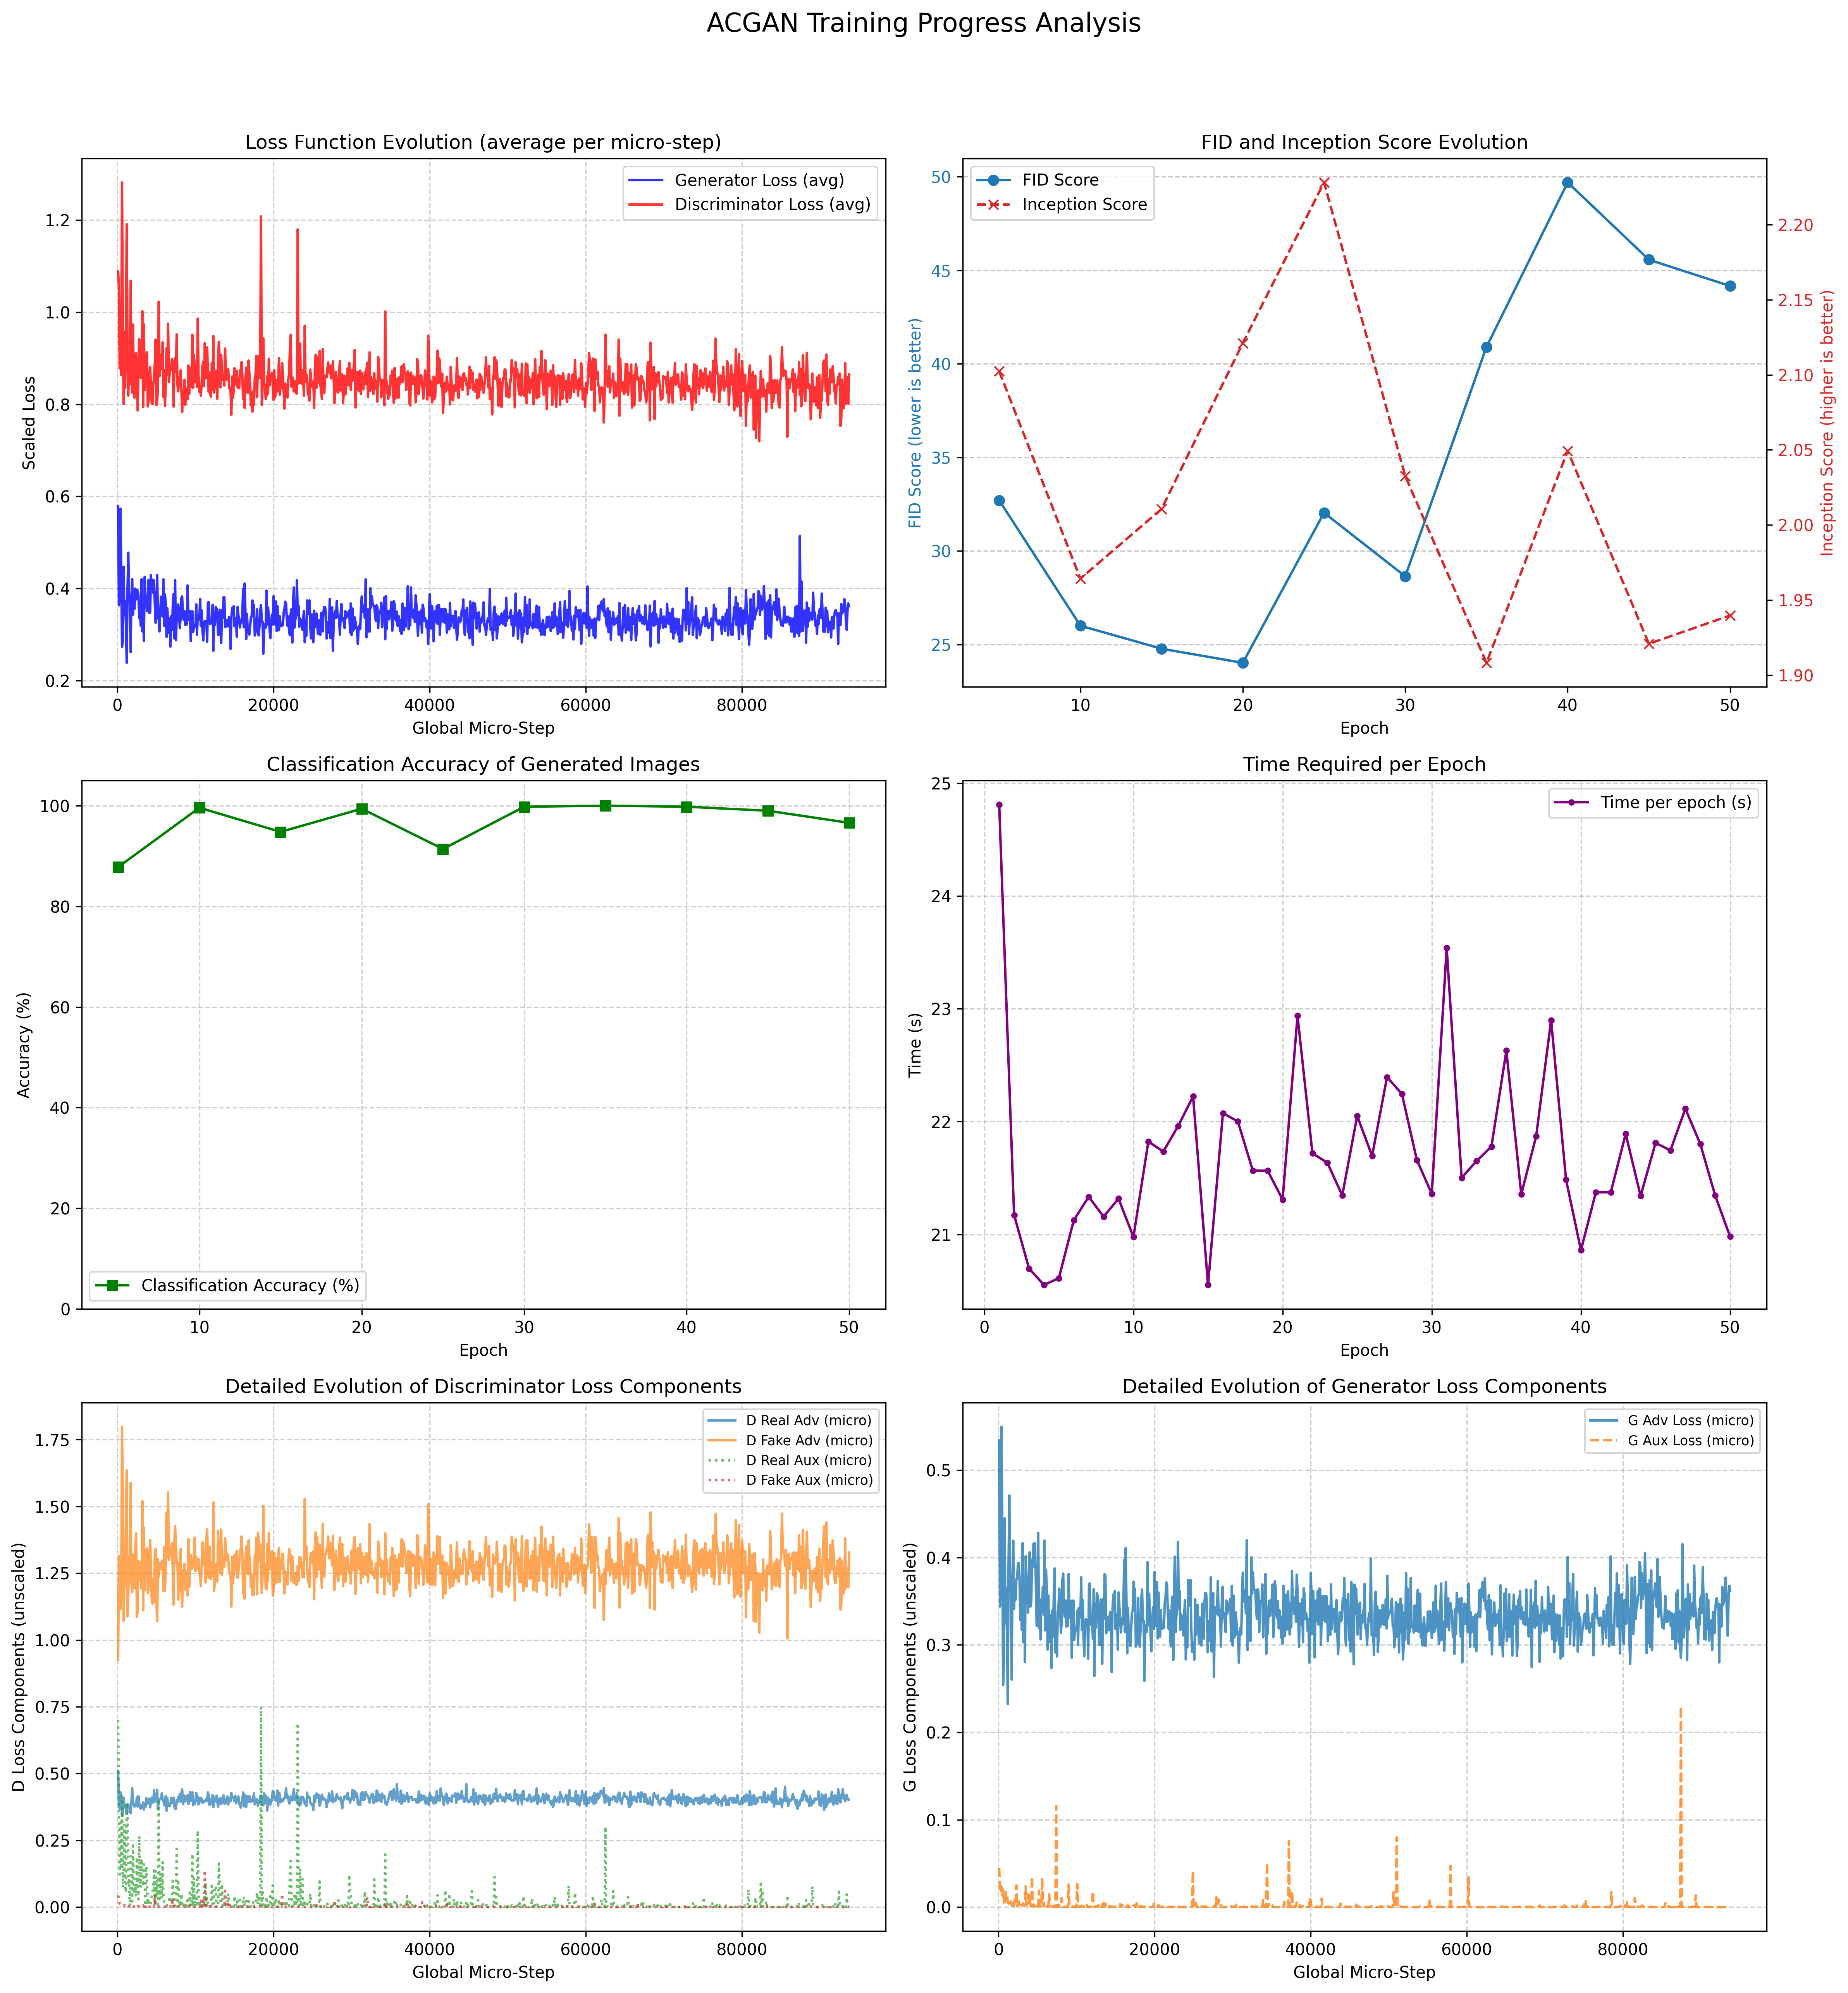

In [ ]:
#@title 10. Visualize training logs (with plot saving)
# Load saved logs, plot six graphs, and save analysis to PNG

print("Plotting and saving training log graphs...")

if os.path.exists(LOG_FILE):
    try:
        with open(LOG_FILE, 'rb') as f:
            logs = pickle.load(f)
        print(f"Logs loaded from {LOG_FILE}")

        fig, axs = plt.subplots(3, 2, figsize=(16, 18))
        fig.suptitle('ACGAN Training Progress Analysis', fontsize=16)

        ax = axs[0, 0]
        ax.plot(logs.get('iterations', []), logs.get('g_loss', []), label='Generator Loss (avg)', alpha=0.8, color='blue')
        ax.plot(logs.get('iterations', []), logs.get('d_loss', []), label='Discriminator Loss (avg)', alpha=0.8, color='red')
        ax.set_xlabel("Global Micro-Step")
        ax.set_ylabel("Scaled Loss")
        ax.set_title("Loss Function Evolution (average per micro-step)")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

        ax = axs[0, 1]
        eval_epochs = logs.get('eval_epochs', [])
        fid_scores = logs.get('fid_scores', [])
        is_scores = logs.get('is_scores', [])
        if eval_epochs and fid_scores:
            color = 'tab:blue'
            ax.set_xlabel("Epoch")
            ax.set_ylabel("FID Score (lower is better)", color=color)
            line1 = ax.plot(eval_epochs, fid_scores, color=color, marker='o', linestyle='-', label='FID Score')
            ax.tick_params(axis='y', labelcolor=color)
            ax.grid(True, axis='y', linestyle='--', alpha=0.7)
            lines = line1
            labels = [l.get_label() for l in lines]

            if is_scores:
                ax2 = ax.twinx()
                color = 'tab:red'
                ax2.set_ylabel("Inception Score (higher is better)", color=color)
                line2 = ax2.plot(eval_epochs, is_scores, color=color, marker='x', linestyle='--', label='Inception Score')
                ax2.tick_params(axis='y', labelcolor=color)
                lines += line2
                labels += [l.get_label() for l in line2]

            ax.legend(lines, labels, loc='best')
        ax.set_title("FID and Inception Score Evolution")

        ax = axs[1, 0]
        cls_acc = logs.get('classification_accuracy', [])
        if eval_epochs and cls_acc:
            ax.plot(eval_epochs, cls_acc, label='Classification Accuracy (%)', marker='s', color='green')
            ax.set_ylim(bottom=0, top=max([0] + [a for a in cls_acc if a is not None] + [105]))
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy (%)")
        ax.set_title("Classification Accuracy of Generated Images")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

        ax = axs[1, 1]
        epoch_nums = logs.get('epochs', [])
        epoch_times = logs.get('epoch_times', [])
        if epoch_nums and epoch_times:
            ax.plot(epoch_nums, epoch_times, label='Time per epoch (s)', marker='.', color='purple')
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Time (s)")
        ax.set_title("Time Required per Epoch")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

        ax = axs[2, 0]
        iterations = logs.get('iterations', [])
        if iterations:
            ax.plot(iterations, logs.get('d_real_adv_loss', []), label='D Real Adv (micro)', alpha=0.7)
            ax.plot(iterations, logs.get('d_fake_adv_loss', []), label='D Fake Adv (micro)', alpha=0.7)
            ax.plot(iterations, logs.get('d_real_aux_loss', []), label='D Real Aux (micro)', alpha=0.7, linestyle=':')
            ax.plot(iterations, logs.get('d_fake_aux_loss', []), label='D Fake Aux (micro)', alpha=0.7, linestyle=':')
        ax.set_xlabel("Global Micro-Step")
        ax.set_ylabel("D Loss Components (unscaled)")
        ax.set_title("Detailed Evolution of Discriminator Loss Components")
        ax.legend(fontsize='small')
        ax.grid(True, linestyle='--', alpha=0.6)

        ax = axs[2, 1]
        if iterations:
            ax.plot(iterations, logs.get('g_adv_loss', []), label='G Adv Loss (micro)', alpha=0.8)
            ax.plot(iterations, logs.get('g_aux_loss', []), label='G Aux Loss (micro)', alpha=0.8, linestyle='--')
        ax.set_xlabel("Global Micro-Step")
        ax.set_ylabel("G Loss Components (unscaled)")
        ax.set_title("Detailed Evolution of Generator Loss Components")
        ax.legend(fontsize='small')
        ax.grid(True, linestyle='--', alpha=0.6)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        plot_save_path = os.path.join(OUTPUT_DIR_IMAGES, "training_analysis_plots.png")
        try:
            plt.savefig(plot_save_path, dpi=300, bbox_inches='tight')
            print(f"Training progress graphs saved to: {plot_save_path}")
        except Exception as e:
            print(f"Error saving training graphs: {e}")

        plt.show()

    except Exception as e:
        print(f"Error loading or plotting logs: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f"Log file '{LOG_FILE}' not found. Cannot plot or save graphs.")

Performing final results analysis...

--- Summary of Best Achieved Metrics ---
Best FID: 24.0182 (Epoch 20)
  - IS at this epoch: 1.8744
  - Accuracy at this epoch: 87.00%
Best IS: 2.2282 (Epoch 25)
Best Classification Accuracy: 100.00% (Epoch 35)
---------------------------------------------

Loading best/final generator weights from: C:\Users\uzivatel 1\Downloads\Clanek\acgan_results\acgan_models_output\acgan_generator_best.pth
Sample comparison graph saved to: C:\Users\uzivatel 1\Downloads\Clanek\acgan_results\real_vs_generated_comparison.png


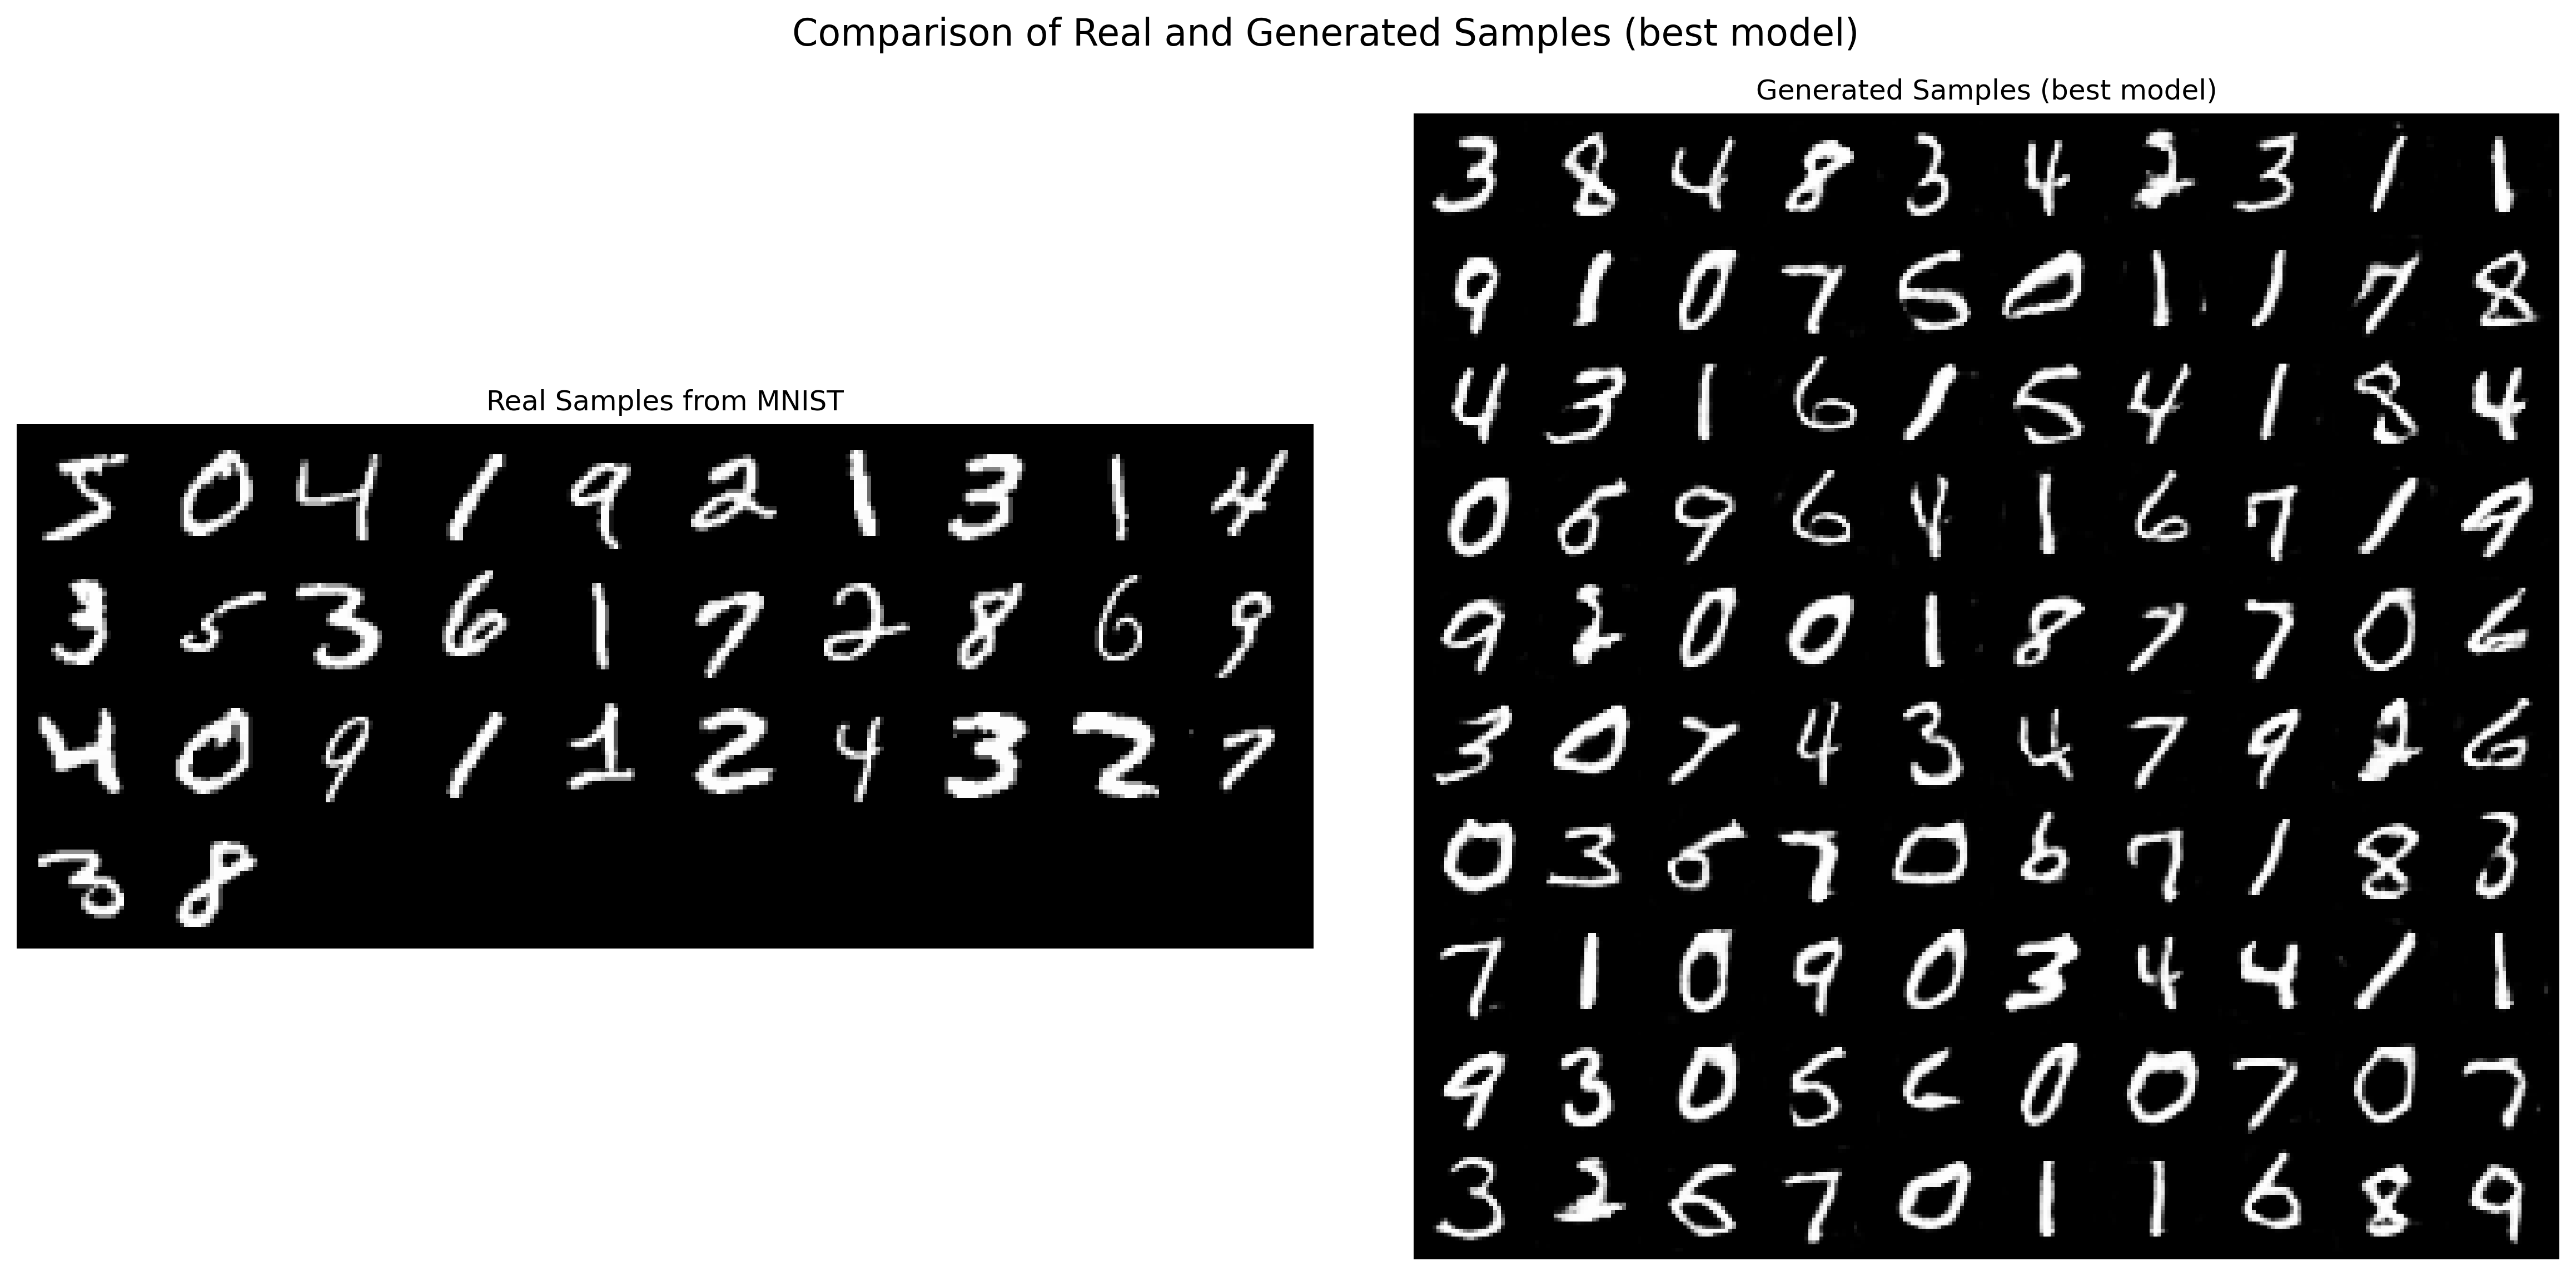

In [ ]:
#@title 11. Qualitative and Quantitative Analysis of Results
# Evaluate best metrics, compare real and generated images, save result graphs

print("Performing final results analysis...")

if os.path.exists(LOG_FILE):
    try:
        with open(LOG_FILE, 'rb') as f:
            logs = pickle.load(f)

        print("\n--- Summary of Best Achieved Metrics ---")

        if logs.get('fid_scores'):
            valid_fids = [(fid, i) for i, fid in enumerate(logs['fid_scores']) if fid is not None and not np.isnan(fid)]
            if valid_fids:
                best_fid_val, best_fid_idx = min(valid_fids, key=lambda item: item[0])
                best_fid_epoch = logs['eval_epochs'][best_fid_idx]
                is_at_best_fid = logs['is_scores'][best_fid_idx] if best_fid_idx < len(logs['is_scores']) and logs['is_scores'][best_fid_idx] is not None else 'N/A'
                acc_at_best_fid = logs['classification_accuracy'][best_fid_idx] if best_fid_idx < len(logs['classification_accuracy']) and logs['classification_accuracy'][best_fid_idx] is not None else 'N/A'
                print(f"Best FID: {best_fid_val:.4f} (Epoch {best_fid_epoch})")
                print(f"  - IS at this epoch: {is_at_best_fid:.4f}" if isinstance(is_at_best_fid, float) else f"  - IS at this epoch: {is_at_best_fid}")
                print(f"  - Accuracy at this epoch: {acc_at_best_fid:.2f}%" if isinstance(acc_at_best_fid, float) else f"  - Accuracy at this epoch: {acc_at_best_fid}")
            else:
                print("FID was not successfully computed in any epoch.")
        else:
            print("No FID values recorded.")

        if logs.get('is_scores'):
            valid_is = [(isc, i) for i, isc in enumerate(logs['is_scores']) if isc is not None and not np.isnan(isc)]
            if valid_is:
                best_is_val, best_is_idx = max(valid_is, key=lambda item: item[0])
                best_is_epoch = logs['eval_epochs'][best_is_idx]
                print(f"Best IS: {best_is_val:.4f} (Epoch {best_is_epoch})")
            else:
                print("IS was not successfully computed in any epoch.")
        else:
            print("No IS values recorded.")

        if logs.get('classification_accuracy'):
            valid_acc = [(acc, i) for i, acc in enumerate(logs['classification_accuracy']) if acc is not None and not np.isnan(acc)]
            if valid_acc:
                best_acc_val, best_acc_idx = max(valid_acc, key=lambda item: item[0])
                best_acc_epoch = logs['eval_epochs'][best_acc_idx]
                print(f"Best Classification Accuracy: {best_acc_val:.2f}% (Epoch {best_acc_epoch})")
            else:
                print("Classification accuracy was not successfully computed in any epoch.")
        else:
            print("No classification accuracy values recorded.")

        print("-" * 45)

    except Exception as e:
        print(f"Error loading or analyzing logs for quantitative summary: {e}")
else:
    print(f"Log file '{LOG_FILE}' not found. Quantitative summary cannot be performed.")

best_generator_path = os.path.join(OUTPUT_DIR_MODELS, 'acgan_generator_best.pth')
if not os.path.exists(best_generator_path):
    print(f"Warning: Best generator file '{best_generator_path}' not found. Using final model.")
    best_generator_path = os.path.join(OUTPUT_DIR_MODELS, 'acgan_generator_final.pth')
    if not os.path.exists(best_generator_path):
        print("Error: Final generator model not found either. Qualitative comparison cannot be performed.")
        best_generator_path = None

comparison_plot_save_path = os.path.join(OUTPUT_DIR_IMAGES, "real_vs_generated_comparison.png")

if best_generator_path:
    print(f"Loading best/final generator weights from: {best_generator_path}")
    try:
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")

        best_generator = Generator(z_dim=Z_DIM, num_classes=NUM_CLASSES, img_channels=IMG_CHANNELS).to(device, memory_format=torch.channels_last)
        best_generator.load_state_dict(torch.load(best_generator_path, map_location=device))
        best_generator.eval()

        num_comparison_samples = 100
        comparison_noise = torch.randn(num_comparison_samples, Z_DIM, device=device)
        comparison_labels = torch.randint(0, NUM_CLASSES, (num_comparison_samples,), device=device)

        with torch.no_grad():
            with torch.autocast(device_type='cuda', enabled=False):
                generated_samples = best_generator(comparison_noise, comparison_labels).detach().cpu()

        try:
            if 'train_loader' not in locals() or train_loader is None:
                raise NameError("train_loader is not defined")
            real_samples, _ = next(iter(train_loader))
            real_samples = real_samples[:num_comparison_samples]
            grid_real = torchvision.utils.make_grid(real_samples, nrow=10, normalize=True)
            grid_real_np = grid_real.permute(1, 2, 0).numpy().astype(np.float32)
        except Exception as loader_err:
            print(f"Failed to load real samples from DataLoader: {loader_err}")
            print("Displaying generated samples only.")
            grid_real_np = None

        grid_generated = torchvision.utils.make_grid(generated_samples, nrow=10, normalize=True)
        grid_generated_np = grid_generated.permute(1, 2, 0).numpy().astype(np.float32)

        if grid_real_np is not None:
            fig, axs = plt.subplots(1, 2, figsize=(16, 8))
            fig.suptitle('Comparison of Real and Generated Samples (best model)', fontsize=16)
            axs[0].imshow(grid_real_np)
            axs[0].set_title('Real Samples from MNIST')
            axs[0].axis('off')
            axs[1].imshow(grid_generated_np)
            axs[1].set_title('Generated Samples (best model)')
            axs[1].axis('off')
        else:
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            fig.suptitle('Generated Samples (best model)', fontsize=16)
            ax.imshow(grid_generated_np)
            ax.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        try:
            plt.savefig(comparison_plot_save_path, dpi=300, bbox_inches='tight')
            print(f"Sample comparison graph saved to: {comparison_plot_save_path}")
        except Exception as e:
            print(f"Error saving comparison graph: {e}")

        plt.show()

    except Exception as e:
        print(f"Error loading model or generating/displaying comparison samples: {e}")
        import traceback
        traceback.print_exc()

In [ ]:
#@title 12. Download results as ZIP archive
# Package model/image folders and logs into a ZIP and trigger download in Colab

import os
from google.colab import files
import shutil

folders_to_zip = [OUTPUT_DIR_MODELS, OUTPUT_DIR_IMAGES]
files_to_zip = [LOG_FILE]

zip_filename = "acgan_results.zip"
work_dir = "/content/"
zip_filepath = os.path.join(work_dir, zip_filename)

print("Starting to package files and folders into ZIP archive...")

temp_archive_dir = os.path.join(work_dir, "temp_for_zipping")
if os.path.exists(temp_archive_dir):
    shutil.rmtree(temp_archive_dir)
os.makedirs(temp_archive_dir)

try:
    print("Copying data for archiving...")
    for folder in folders_to_zip:
        if os.path.isdir(folder):
            base_name = os.path.basename(folder)
            shutil.copytree(folder, os.path.join(temp_archive_dir, base_name))
            print(f" - Folder '{base_name}' copied.")
        else:
            print(f" - Warning: Folder '{folder}' not found.")

    for file_path in files_to_zip:
        if os.path.isfile(file_path):
            shutil.copy(file_path, temp_archive_dir)
            print(f" - File '{os.path.basename(file_path)}' copied.")
        else:
            print(f" - Warning: File '{file_path}' not found.")

    print("Creating ZIP archive...")
    shutil.make_archive(os.path.join(work_dir, zip_filename.replace('.zip', '')),
                        'zip',
                        root_dir=temp_archive_dir)

    print(f"ZIP archive '{zip_filepath}' successfully created.")
    shutil.rmtree(temp_archive_dir)

    print(f"Initiating download of file '{zip_filename}'...")
    files.download(zip_filepath)
    print("Download started. File should appear in your browser.")

except Exception as e:
    print(f"An error occurred while creating or downloading ZIP archive: {e}")
    if os.path.exists(temp_archive_dir):
        shutil.rmtree(temp_archive_dir)

Starting to package files and folders into ZIP archive...
Copying data for archiving...
 - Folder 'acgan_models_output' copied.
 - Folder 'acgan_images_output' copied.
 - File 'acgan_training_logs.pkl' copied.
Creating ZIP archive...
ZIP archive '/content/acgan_results.zip' successfully created.
Initiating download of file 'acgan_results.zip'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started. File should appear in your browser.


## Discussion and Conclusion

This notebook presents a classical ACGAN baseline for MNIST digit generation. The implementation achieves competitive results:

- **FID of 24.02** at epoch 20, indicating good distributional similarity to real MNIST
- **Inception Score of 2.23** at epoch 25
- **100% classification accuracy** on generated samples by epoch 35

### Comparison with QACGAN
In the accompanying paper, we present QACGAN—a hybrid quantum-classical variant that augments the generator objective with a VQE-based energy term. Key comparative findings:

| Aspect | ACGAN (this notebook) | QACGAN |
|--------|----------------------|--------|
| Best FID | 24.02 (epoch 20) | 19.92–23.91 (epochs 5–10) |
| Accuracy @ 5 epochs | 87.8% | 99–100% |
| Training time | ~27 min (50 epochs) | ~7–14 hours (5–10 epochs) |

QACGAN achieves faster convergence to high classification accuracy but at significantly higher computational cost due to quantum simulation overhead.

### Limitations
- Evaluation uses relatively small sample sizes (1,000 for FID/IS, 500 for accuracy)
- Results are specific to MNIST; generalization to more complex datasets requires further study

### Future Directions
- Incorporate modern GAN techniques (spectral normalization, self-attention)
- Experiment with larger latent spaces
- Extend to more challenging datasets (Fashion-MNIST, CIFAR-10)